# Introduction to EOFS

In [78]:
#!wget https://downloads.psl.noaa.gov/Datasets/COBE/sst.mon.mean.nc

In [31]:
import numpy as np
from scipy import signal
import numpy.polynomial.polynomial as poly

import matplotlib.pyplot as plt
from eofs.xarray import Eof
import cartopy.crs as ccrs
import cartopy.feature as cfeature

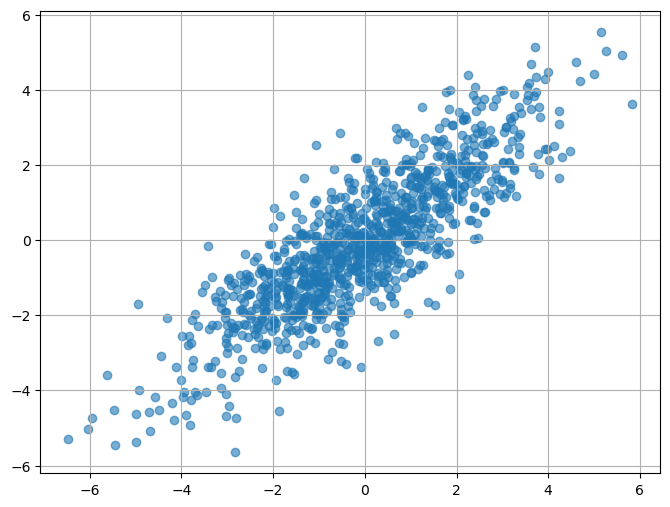

In [91]:
n_samples = 1000

x1 = np.random.normal(0, 2, n_samples)
x2 = 0.8 * x1 + np.random.normal(0, 1, n_samples)
data = np.vstack((x1, x2)).T  # Combine into a 2D array

ds = xr.DataArray(data, dims=("time", "space"), coords={"space": ["X1", "X2"]})

fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(x1, x2, alpha=0.6, label="Data")
plt.grid(True)
plt.show()

In [133]:
solver = Eof(ds)
eofs = solver.eofs(neofs=2)  # Get EOF spatial patterns
pcs = solver.pcs(npcs=2, pcscaling=1)  # Get principal components

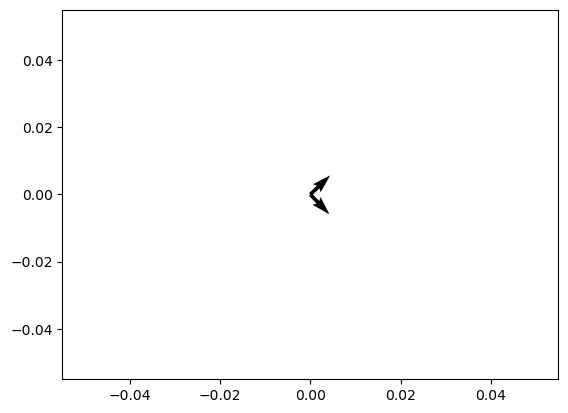

In [134]:
plt.quiver(0, 0, eofs.isel(mode=0)[0], eofs.isel(mode=0)[1])
plt.quiver(0, 0, eofs.isel(mode=1)[0], eofs.isel(mode=1)[1])

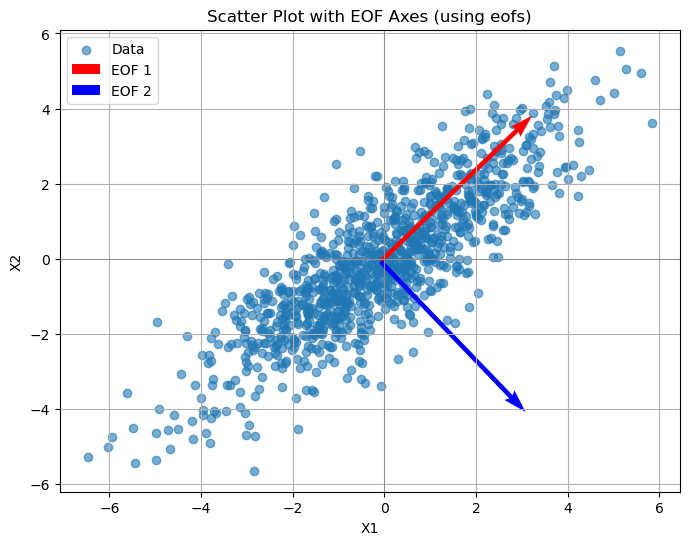

In [135]:
mean_x1, mean_x2 = np.mean(x1), np.mean(x2)
scaling = 5  #

fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(x1, x2, alpha=0.6, label="Data")
plt.grid(True)

plt.quiver(mean_x1, mean_x2, eofs.sel(space="X1")[0] * scaling, eofs.sel(space="X2")[0] * scaling,
           color="red", scale_units="xy", scale=1, label="EOF 1")

# EOF2: Second dominant axis
plt.quiver(mean_x1, mean_x2, eofs.sel(space="X1")[1] * scaling, eofs.sel(space="X2")[1] * scaling,
           color="blue", scale_units="xy", scale=1, label="EOF 2")

# Plot styling
plt.axhline(0, color="grey", lw=0.5)
plt.axvline(0, color="grey", lw=0.5)
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Scatter Plot with EOF Axes (using eofs)")
plt.legend()

How did we do that?

In [136]:
data.shape # is already (time, space)

(1000, 2)

In [137]:
data_mean = np.mean(data, axis=0)  
data_anomalies = data - data_mean 

In [138]:
cov_matrix = np.cov(data_anomalies, rowvar=False)  # Covariance across space

In [139]:
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)  # Solve for eigenvalues/vectors

In [140]:
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = -1*eigenvectors[:, sorted_indices]

In [141]:
pcs = np.dot(data_anomalies, eigenvectors)

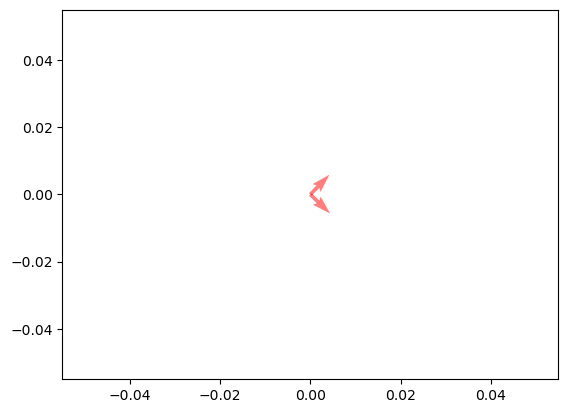

In [142]:
plt.quiver(0, 0, eigenvectors[0][0],eigenvectors[0][1], color="red",alpha=.5)
plt.quiver(0, 0, eigenvectors[1][0],eigenvectors[1][1], color="red",alpha=.5)

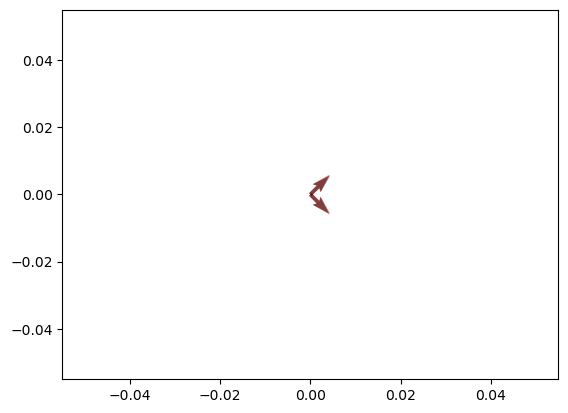

In [143]:
plt.quiver(0, 0, eigenvectors[0][0],eigenvectors[0][1], color="red",alpha=.5)
plt.quiver(0, 0, eigenvectors[1][0],eigenvectors[1][1], color="red",alpha=.5)
plt.quiver(0, 0, eofs.isel(mode=0)[0], eofs.isel(mode=0)[1],alpha=0.5)
plt.quiver(0, 0, eofs.isel(mode=1)[0], eofs.isel(mode=1)[1],alpha=.5)

In [144]:
infile = "sst.mon.mean.nc"

In [145]:
dataset = xr.open_dataset(infile)

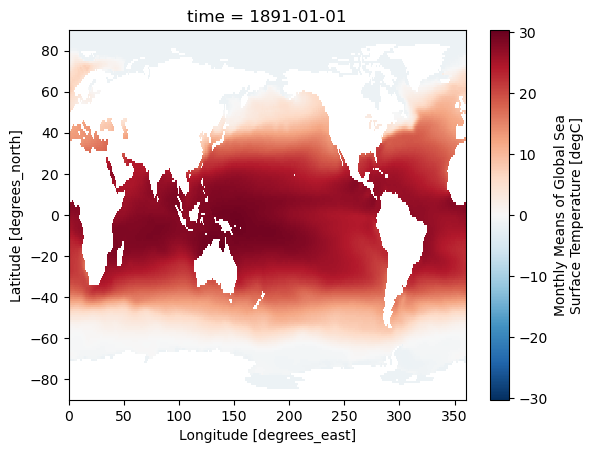

In [146]:
dataset.isel(time = 0).sst.plot()

In [122]:
def detrend_dim(da, dim, deg=1):
    """
    Detrend data along a specified dimension.

    This function removes a polynomial trend along a given dimension by fitting 
    and subtracting a polynomial of specified degree.

    Parameters
    ----------
    da : xr.DataArray
        The data array to detrend.
    dim : str
        The dimension along which to detrend the data, typically representing time.
    deg : int, optional
        The degree of the polynomial for detrending. Default is 1 (linear detrend).

    Returns
    -------
    xr.DataArray
        The detrended data array with the fitted trend removed along the specified dimension.
    """

    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

In [123]:
detrendedSST = detrend_dim(dataset['sst'], dim="time")

In [124]:
monthly_mean = detrendedSST.groupby('time.month').mean('time')
sst_deseasonalized = detrendedSST.groupby('time.month') - monthly_mean
sst_deseasonalized = sst_deseasonalized.drop("month")

In [125]:
coslat = np.cos(np.deg2rad(dataset.lat.data))
wgts = np.sqrt(coslat)[..., np.newaxis]

solver = Eof(sst_deseasonalized, weights=wgts)

In [126]:
eof1 = solver.eofs(neofs=10)
pc1  = solver.pcs(npcs=10, pcscaling=0)
varfrac = solver.varianceFraction()
lambdas = solver.eigenvalues()

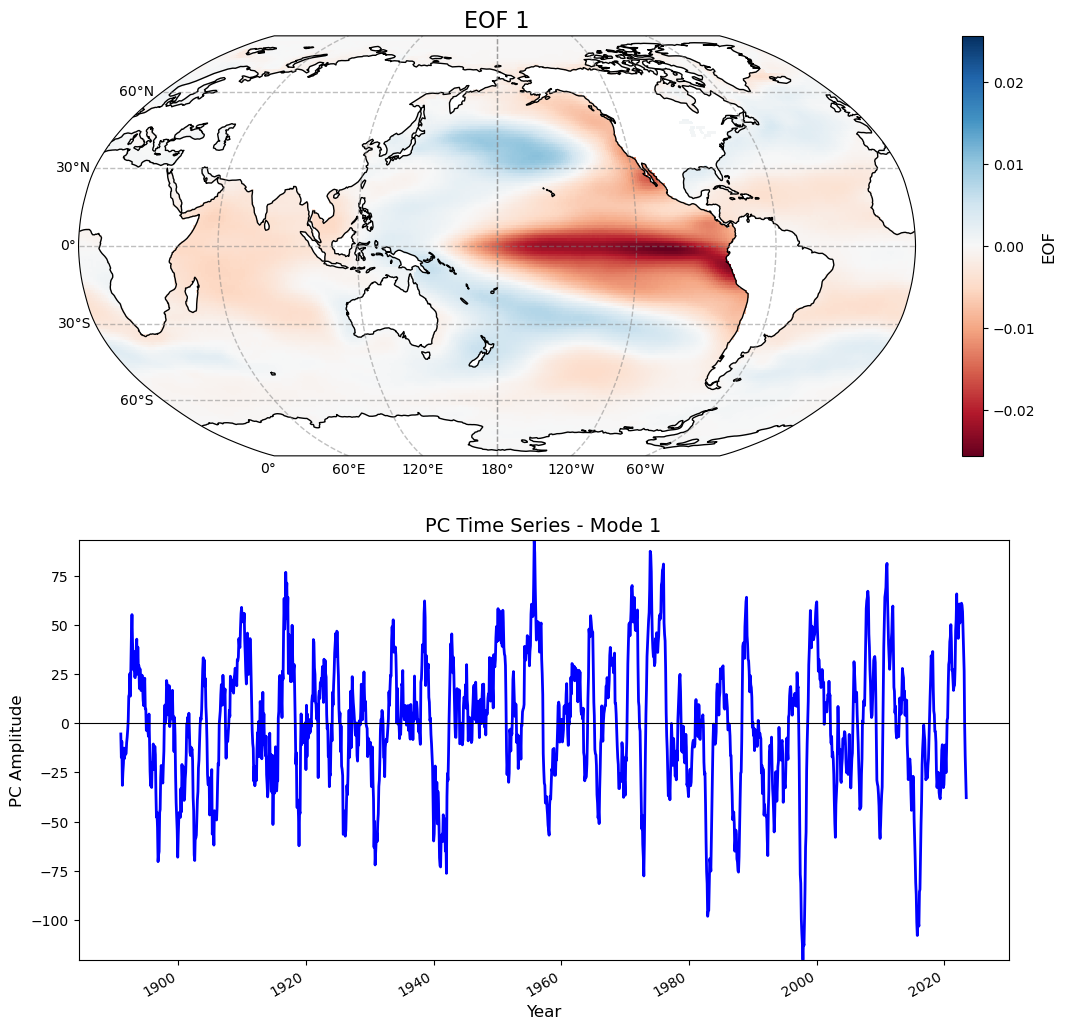

In [127]:
# Define parallels and meridians
parallels = np.arange(-90, 90, 30.)
meridians = np.arange(-180, 180, 30.)

# Define lon and lat
lon = dataset.lon
lat = dataset.lat

for i in range(0, 1):
    fig = plt.figure(figsize=(12, 12))  # Larger figure for better clarity

    # --- Plot EOF Field ---
    ax1 = plt.subplot(2, 1, 1, projection=ccrs.Robinson(central_longitude=180))
    
    # Plot EOF with proper transformation
    cs = eof1.isel(mode=i).plot(
        ax=ax1, 
        cmap=plt.cm.RdBu, 
        transform=ccrs.PlateCarree(),
        add_colorbar=False  # Avoid duplicate colorbars
    )
    
    # Add coastlines and gridlines
    ax1.coastlines()
    gl = ax1.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = True
    gl.bottom_labels = True

    # Add colorbar manually
    cb = plt.colorbar(cs, ax=ax1, orientation='vertical', fraction=0.05, pad=0.05)
    cb.set_label('EOF', fontsize=12)

    # Title
    ax1.set_title(f'EOF {i + 1}', fontsize=16)

    # --- Plot PC Time Series ---
    ax2 = plt.subplot(2, 1, 2)
    pc1.isel(mode=i).plot(ax=ax2, linewidth=2, color='blue')
    ax2.axhline(0, color='k', linewidth=0.8)
    ax2.set_xlabel('Year', fontsize=12)
    ax2.set_ylabel('PC Amplitude', fontsize=12)
    ax2.set_ylim(np.min(pc1), np.max(pc1))
    ax2.set_title(f'PC Time Series - Mode {i + 1}', fontsize=14)
    ax1.set_aspect("auto")

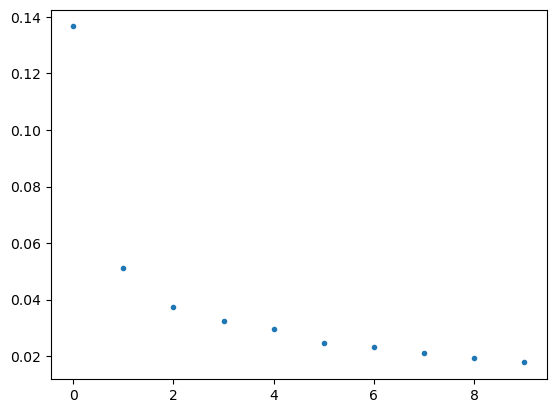

In [132]:
plt.plot(varfrac.isel(mode=slice(0,10)), ls="", marker=".")

In [175]:
slp = xr.open_dataset("/students_files/data/SLP.nc").msl
slp

<xarray.DataArray 'msl' (time: 1320, latitude: 181, longitude: 360)>
[86011200 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * time       (time) datetime64[ns] 1900-01-01 1900-02-01 ... 2009-12-01
Attributes:
    units:          Pa
    long_name:      Mean sea level pressure
    standard_name:  air_pressure_at_mean_sea_level

In [176]:
#| export
def adjust_lon_lat(ds, lon_name, lat_name, reverse = False):
    """Adjusts longitude from 0 to 360 to -180 to 180 and reverses latitude."""

    if reverse == True:
        ds = ds.reindex({lat_name:ds[lat_name][::-1]})

    ds['_longitude_adjusted'] = xr.where(
        ds[lon_name] > 180,
        ds[lon_name] - 360,
        ds[lon_name])

    ds = (ds
          .swap_dims({lon_name: '_longitude_adjusted'})
          .sel(**{'_longitude_adjusted': sorted(ds._longitude_adjusted)})
          .drop(lon_name))

    ds = ds.rename({'_longitude_adjusted': lon_name})

    return ds

In [177]:
slp = adjust_lon_lat(slp, lon_name="longitude", lat_name="latitude", reverse=True)

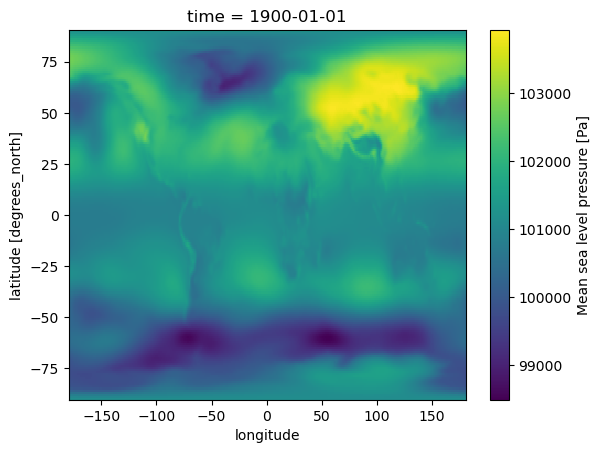

In [178]:
slp.isel(time=0).plot()

In [173]:
slp_djf

<xarray.DataArray 'msl' (time: 330, latitude: 0, longitude: 41)>
array([], shape=(330, 0, 41), dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 4.0 ... 37.0 38.0 39.0 40.0
  * latitude   (latitude) float32 
  * time       (time) datetime64[ns] 1900-01-01 1900-02-01 ... 2009-12-01

In [179]:
slp_djf = slp.sel(time=slp['time'].dt.month.isin([12, 1, 2]))

In [180]:
slp_djf = slp_djf.sel(longitude=slice(-80,40), latitude=slice(20,90))

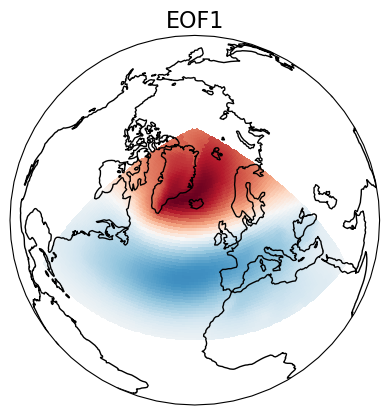

In [185]:
# Compute anomalies by removing the time-mean.
slp_djf = slp_djf - slp_djf.mean(dim='time')

# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(slp_djf.coords['latitude'].values)).clip(0., 1.)
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(slp_djf, weights=wgts)

# Retrieve the leading EOF, expressed as the covariance between the leading PC
# time series and the input SLP anomalies at each grid point.
eof1 = solver.eofsAsCovariance(neofs=1)

# Plot the leading EOF expressed as covariance in the European/Atlantic domain.
proj = ccrs.Orthographic(central_longitude=-20, central_latitude=60)
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
eof1.isel(mode=0).plot.pcolormesh(ax=ax, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=False)
ax.set_title('EOF1', fontsize=16)
plt.show()